# 3D Image Volume - Image Processing Tutorial Walkthrough 
#### Written by Sydney Packard
#### based on the Crocker & Grier method, and Trackpy and freud documentation
#### for Stewart Lab use only
#### Email: srpackard@wpi.edu

## Setup IPython, pims and trackpy

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('figure',  figsize=(10, 6))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import os
import tifffile

%matplotlib widget
from matplotlib.widgets import Slider

from scipy.ndimage import label, find_objects
from skimage.measure import regionprops


import warnings
warnings.filterwarnings("ignore", module="matplotlib")

## Rename the files into a format readable by ImageSequenceND

In [2]:
# --------- USER SETTINGS ---------
imageslices = 20 ## Define how many images you have in your batch to process, 1 more than the actual number of images due to numbering starting at 0
#images in folder are named as strain+imageday
#folder = "Untreated_60x"; ## Define the Strain Name 
experiment = "UntreatedBinary_Cells"
date = "08-26-2025"
sample = "Series7-Smoothed"
username = "spack"; ## Your username for your computer
foldername = "Data/Keyence"; ## This just defines the folder the images are in that you want to process
## END OF USER INPUT ##

In [3]:
import os


#"C:\Users\spack\OneDrive - Worcester Polytechnic Institute (wpi.edu)\Documents\Data\Keyence\08-26-2025\NaIO4Binary_Cells\Series1\NaIO4Binary_Cells_Series1_Z00_C0_T0.tif"
newpath = r"C:/Users/"+username+"/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/"+foldername+"/"+date+"/"+sample

if not os.path.exists(newpath):
    os.makedirs(newpath)
#"C:\Users\spack\OneDrive - Worcester Polytechnic Institute (wpi.edu)\Documents\Data\Keyence\06-04-2025\DNaseIBinary_60x\XY01\DNaseI_60x_XY01_Z0_C0_T0.tif"
for i in range(2, imageslices):
    if i < 10:
        os.rename("C:/Users/"+username+"/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/"+foldername+"/"+date+"/"+experiment+"/"+sample+"/"+experiment+"_"+sample+"_Z0"+str(i)+"_C0_T0.tif",
                  "C:/Users/"+username+"/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/"+foldername+"/"+date+"/"+experiment+"/"+sample+"/"+experiment+"_"+sample+"_t00_z0"+str(i)+".tif");
    elif i in range (10, 100):
        os.rename("C:/Users/"+username+"/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/"+foldername+"/"+date+"/"+experiment+"/"+sample+"/"+experiment+"_"+sample+"_Z"+str(i)+"_C0_T0.tif",
                  "C:/Users/"+username+"/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/"+foldername+"/"+date+"/"+experiment+"/"+sample+"/"+experiment+"_"+sample+"_t00_z"+str(i)+".tif");
   # elif i in range (100, imageslices):
    #    os.rename("C:/Users/"+username+"/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/"+foldername+"/"+date+"/"+sample+"/"+experiment+"_"+sample+"_Z"+str(i)+"_C0_T0.tif",
     #             "C:/Users/"+username+"/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/"+foldername+"/"+date+"/"+sample+"/"+experiment+"_"+sample+"_t000_z"+str(i)+".tif");

# Extract z y x particle centroids from 3D confocal images using TrackPy

## Import 3D images

In [4]:

def load_tif_stack(folder_path, file_pattern="*.tif", sort=True):
    from glob import glob

    file_paths = glob(os.path.join(folder_path, file_pattern))
    if sort:
        file_paths.sort()  # Sort by filename — check this works for your Z-order

    images = [tifffile.imread(fp) for fp in file_paths]
    volume = np.stack(images, axis=0)  # Shape: (z, y, x)

    return volume

In [5]:
folder = r"C:/Users/"+username+"/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/"+foldername+"/"+date+"/"+experiment+"/"+sample
#"+experiment+"_"+sample+"*.tif""
volume = load_tif_stack(folder)

print("Volume shape:", volume.shape)
print("Min/max:", volume.min(), volume.max())

Volume shape: (76, 2048, 2048)
Min/max: 0 255


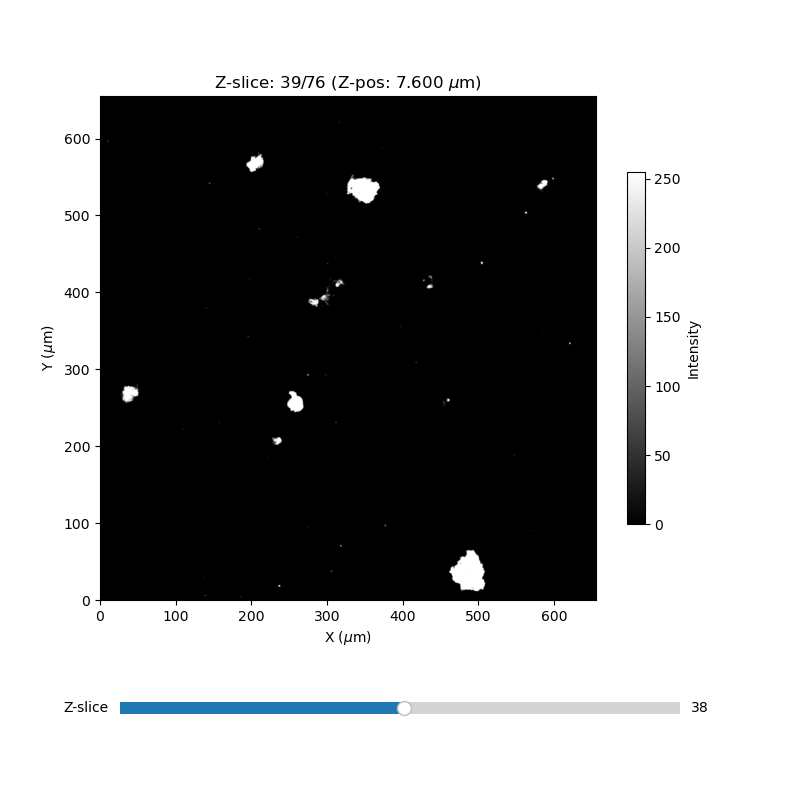

In [9]:
# --- Your specified pixel dimensions ---
x_y_pixel_dimension = 0.32  # microns per pixel
z_step = 0.2                 # microns

# --- Create Scrollable Stack ---

def create_scrollable_stack(volume, pixel_size_xy, pixel_size_z):
    num_slices = volume.shape[0]
    initial_slice = num_slices // 2 # Start at the middle slice

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.subplots_adjust(bottom=0.25) # Make space for the slider

    # Display the initial slice
    # Use aspect='auto' or 'equal' depending on whether you want to preserve aspect ratio
    # with physical dimensions or just show pixel-wise square.
    # For microscope images, 'auto' often looks better to fill the display.
    # extent: [left, right, bottom, top] -> [xmin, xmax, ymin, ymax]
    # For imshow, the origin is 'upper' by default, so y values are flipped.
    # If origin='lower', ymax is at the top. Let's stick with default 'upper'.
    # X-axis will go from 0 to width_in_microns
    # Y-axis will go from 0 to height_in_microns (but displayed inverted if origin='upper')

    # Calculate physical dimensions for display
    width_microns = volume.shape[2] * pixel_size_xy
    height_microns = volume.shape[1] * pixel_size_xy

    # We want the y-axis to increase upwards physically, so let's set origin='lower'
    # and adjust the extent accordingly.
    im = ax.imshow(volume[initial_slice, :, :], cmap='gray', origin='lower',
                   extent=[0, width_microns, 0, height_microns])

    ax.set_title(f"Z-slice: {initial_slice+1}/{num_slices} (Z-pos: {initial_slice * pixel_size_z:.3f} $\mu$m)")
    ax.set_xlabel(f"X ($\mu$m)")
    ax.set_ylabel(f"Y ($\mu$m)")
    ax.set_aspect('auto') # Adjust aspect ratio automatically to fit the figure

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, shrink=0.7)
    cbar.set_label("Intensity")

    # Create the slider
    ax_slider = plt.axes([0.15, 0.1, 0.7, 0.03]) # [left, bottom, width, height]
    slider = Slider(ax_slider, 'Z-slice', 0, num_slices - 1, valinit=initial_slice, valstep=1,
                    valfmt='%d')

    # Update function for the slider
    def update(val):
        slice_idx = int(slider.val)
        im.set_data(volume[slice_idx, :, :])
        ax.set_title(f"Z-slice: {slice_idx+1}/{num_slices} (Z-pos: {slice_idx * pixel_size_z:.3f} $\mu$m)")
        fig.canvas.draw_idle() # Redraw the figure

    slider.on_changed(update)

    # Optional: Add keyboard navigation (up/down arrows)
    def key_press(event):
        if event.key == 'up' or event.key == 'right':
            current_val = slider.val
            if current_val < num_slices - 1:
                slider.set_val(current_val + 1)
        elif event.key == 'down' or event.key == 'left':
            current_val = slider.val
            if current_val > 0:
                slider.set_val(current_val - 1)
        fig.canvas.draw_idle()

    fig.canvas.mpl_connect('key_press_event', key_press)

    plt.show()

# Call the function to create the scrollable stack
create_scrollable_stack(volume, x_y_pixel_dimension, z_step)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from skimage.measure import regionprops
import pandas as pd
import os
import tifffile # Make sure tifffile is imported

# --- Your specified pixel dimensions ---
x_y_pixel_dimension = 0.32 # microns per pixel
z_step = 0.1                 # microns

# Define voxel spacing for correct calculations
voxel_spacing = np.array([z_step, x_y_pixel_dimension, x_y_pixel_dimension])
voxel_volume = z_step * x_y_pixel_dimension * x_y_pixel_dimension # Volume of a single voxel

# --- Preprocessing: Ensure binary (0s and 1s) ---
binary_volume = (volume > 0).astype(bool)

# --- Step 1: Label connected components ---
structure = np.ones((3,3,3), dtype=bool) # 26-connectivity
labeled_volume, num_features = label(binary_volume, structure=structure)
print(f"\nFound {num_features} bright objects.")

if num_features == 0:
    print("No objects found to analyze. Exiting.")
else:
    # --- Step 2: Calculate 3D Region Properties ---
    props = regionprops(labeled_volume, intensity_image=binary_volume)

    results_data = []

    for prop in props:
        # Filter out very small spurious objects (e.g., less than 5 voxels)
        if prop.area < 5: # prop.area is voxel count for older skimage versions
            continue

        # Manually calculate Volume (µm^3)
        volume_microns_cubed = prop.area * voxel_volume

        # Centroid in physical units (prop.centroid gives Z, Y, X in pixels)
        centroid_phys_z = prop.centroid[0] * z_step
        centroid_phys_y = prop.centroid[1] * x_y_pixel_dimension
        centroid_phys_x = prop.centroid[2] * x_y_pixel_dimension

        # Get the covariance matrix of the object's pixel coordinates
        coords = prop.coords # (N, 3) for (z, y, x)
        physical_coords = coords * voxel_spacing

        # Calculate the covariance matrix using centered physical coordinates
        centered_physical_coords = physical_coords - physical_coords.mean(axis=0)
        covariance_matrix = np.cov(centered_physical_coords, rowvar=False)

        # Get eigenvalues (variances along principal axes) and eigenvectors (directions)
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1] # Sort in descending order
        sorted_eigenvalues = eigenvalues[sorted_indices] # lambda_1, lambda_2, lambda_3 (sorted)

        # Ensure values are non-negative for sqrt and non-zero for divisions
        # Use np.maximum to replace any near-zero or negative eigenvalues with a tiny positive value
        # This is for numerical stability in ratios, especially for very small objects.
        eigenvalues_stable = np.maximum(sorted_eigenvalues, 1e-18)

        L1_eigen = eigenvalues_stable[0] # Corresponds to lambda_1
        L2_eigen = eigenvalues_stable[1] # Corresponds to lambda_2
        L3_eigen = eigenvalues_stable[2] # Corresponds to lambda_3

        # Principal axis lengths (twice the standard deviation along each principal axis)
        # These are L1, L2, L3 used for your asphericity calculation from previous step
        principal_axes_radii = np.sqrt(eigenvalues_stable)
        L1_length = principal_axes_radii[0] * 2
        L2_length = principal_axes_radii[1] * 2
        L3_length = principal_axes_radii[2] * 2

        # 3D Maximum Diameter (Approximation):
        max_diameter_approx = L1_length # The longest principal axis length

        # Anisotropy (1 - L3/L1) - still an option, but we'll add the new one
        anisotropy_ratio = 1 - (L3_length / L1_length) if L1_length != 0 else 0

        # Asphericity (Custom Scale) - as implemented in the previous step
        if (L1_length - L3_length) == 0:
            asphericity_custom_scale = 0.0
        else:
            asphericity_custom_scale = (L1_length - 2*L2_length + L3_length) / (L1_length - L3_length)
            if asphericity_custom_scale < 0:
                asphericity_custom_scale *= 2

        # --- NEW Anisotropy Calculation: k^2 = (b^2 + (3/4)*c^2) / Rg^4 ---
        # Where b = lambda_1 - 0.5 * (lambda_2 + lambda_3) (Asphericity of gyration tensor)
        # And c = lambda_2 - lambda_3 (Acylindricity of gyration tensor)
        # And Rg^2 = lambda_1 + lambda_2 + lambda_3 (Radius of gyration squared)

        # Ensure the sum of eigenvalues is not zero for Rg_squared
        Rg_squared = L1_eigen + L2_eigen + L3_eigen
        
        if Rg_squared == 0: # Handle case of zero size object
            anisotropy_k_squared = 0.0
        else:
            # Numerator terms
            b_gyration = L1_eigen - 0.5 * (L2_eigen + L3_eigen)
            c_gyration = L2_eigen - L3_eigen

            # Calculate k^2
            anisotropy_k_squared = (b_gyration**2 + (3/4) * c_gyration**2) / (Rg_squared**2)

        # Equivalent Diameter (µm) from calculated physical volume
        equivalent_diameter_microns = (6 * volume_microns_cubed / np.pi)**(1/3) if volume_microns_cubed > 0 else 0

        # Store results for Excel export, selecting specific columns
        results_data.append({
            'Object Label': prop.label,
            'Max Diameter Approx (µm)': max_diameter_approx,
            'Asphericity': asphericity_custom_scale,
            'Anisotropy (k^2)': anisotropy_k_squared # The new anisotropy definition
        })

    # Convert results to a pandas DataFrame
    results_df = pd.DataFrame(results_data)

    print("\n--- Object Properties ---")
    print(results_df.to_string())

    # --- Export to Excel ---
    # This path construction assumes `username`, `foldername`, `date`, `experiment`, `sample` are defined in the broader script.
    excel_output_path = rf"C:/Users/{username}/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/{foldername}/{date}/{experiment}/{sample}/{experiment}_{sample}_released_cell_properties.xlsx"
    try:
        results_df.to_excel(excel_output_path, index=False)
        print(f"\nResults saved to Excel file: {excel_output_path}")
    except Exception as e:
        print(f"\nError saving to Excel: {e}")
        print("Make sure 'openpyxl' is installed (pip install openpyxl).")


Found 15252 bright objects.

--- Object Properties ---
       Object Label  Max Diameter Approx (µm)  Asphericity  Anisotropy (k^2)
0                 1                  3.178101     0.027677          0.480759
1                 2                  2.955196    -1.279423          0.272333
2                 3                  3.033422     0.031360          0.485738
3                 4                  4.617507     0.142681          0.540145
4                 5                  0.670902    -0.729143          0.305479
5                 6                  2.474407    -1.328843          0.246858
6                 7                  1.350507    -0.987970          0.299436
7                 8                  2.782488    -0.298236          0.423753
8                 9                  1.403087    -1.484910          0.258238
9                10                  1.439603    -1.172415          0.279220
10               11                  0.937254    -0.739904          0.322906
11               12 

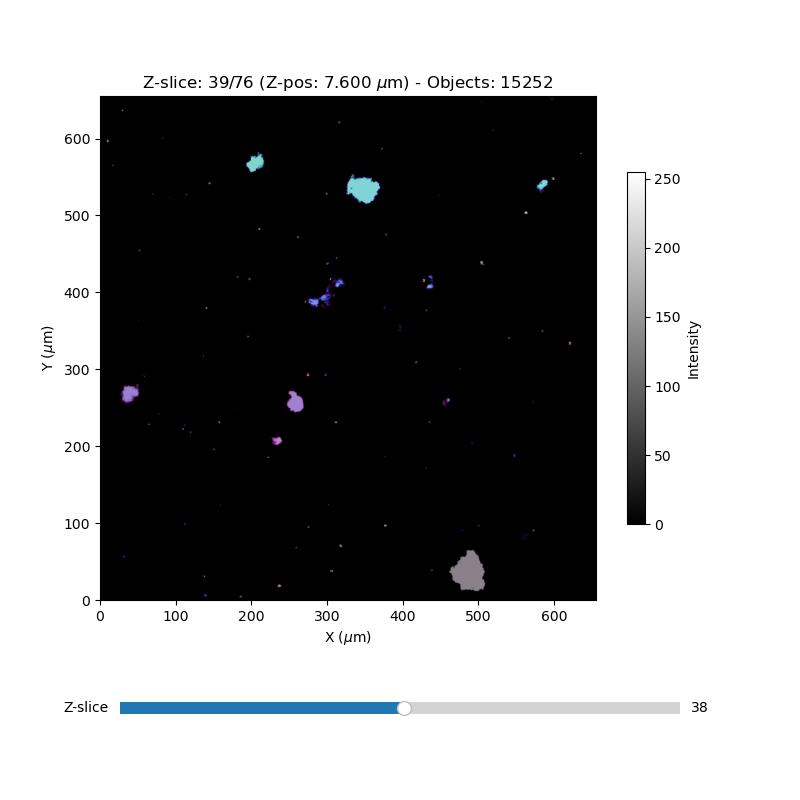

In [10]:
# --- Create Scrollable Stack with Overlaid Outlines ---
def create_scrollable_stack_with_outlines(volume, labeled_data, pixel_size_xy, pixel_size_z, num_objects_detected):
    num_slices = volume.shape[0]
    initial_slice = num_slices // 2 # Start at the middle slice

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.subplots_adjust(bottom=0.25) # Make space for the slider

    # Calculate physical dimensions for display
    width_microns = volume.shape[2] * pixel_size_xy
    height_microns = volume.shape[1] * pixel_size_xy
    plot_extent = [0, width_microns, 0, height_microns]

    # Display the initial raw image slice
    im_raw = ax.imshow(volume[initial_slice, :, :], cmap='gray', origin='lower',
                        extent=plot_extent)

    # Overlay the initial labeled image slice
    # Use alpha for transparency and a distinct colormap for labels
    im_labeled = ax.imshow(labeled_data[initial_slice, :, :], cmap='nipy_spectral', alpha=0.5, origin='lower',
                           extent=plot_extent)


    ax.set_title(f"Z-slice: {initial_slice+1}/{num_slices} (Z-pos: {initial_slice * pixel_size_z:.3f} $\mu$m) - Objects: {num_objects_detected}")
    ax.set_xlabel(f"X ($\mu$m)")
    ax.set_ylabel(f"Y ($\mu$m)")
    ax.set_aspect('auto') # Adjust aspect ratio automatically to fit the figure

    # Add a colorbar for the original image intensity
    cbar_raw = fig.colorbar(im_raw, ax=ax, shrink=0.7, label="Intensity")

    # If you want a separate colorbar for the labels, uncomment and adjust:
    # if num_objects_detected > 0:
    #     cbar_labels = fig.colorbar(im_labeled, ax=ax, shrink=0.7, label="Object Label ID")
    #     ticks = np.linspace(1, num_objects_detected, num_objects_detected, dtype=int)
    #     cbar_labels.set_ticks(ticks)


    # Create the slider
    ax_slider = plt.axes([0.15, 0.1, 0.7, 0.03]) # [left, bottom, width, height]
    slider = Slider(ax_slider, 'Z-slice', 0, num_slices - 1, valinit=initial_slice, valstep=1,
                    valfmt='%d')

    # Update function for the slider and mouse scroll
    def update(val):
        slice_idx = int(slider.val)
        im_raw.set_data(volume[slice_idx, :, :])
        im_labeled.set_data(labeled_data[slice_idx, :, :]) # Update labeled overlay
        ax.set_title(f"Z-slice: {slice_idx+1}/{num_slices} (Z-pos: {slice_idx * pixel_size_z:.3f} $\mu$m) - Objects: {num_objects_detected}")
        fig.canvas.draw_idle() # Redraw the figure

    slider.on_changed(update)

    # Keyboard navigation (up/down arrows)
    def key_press(event):
        if event.key == 'up' or event.key == 'right':
            current_val = slider.val
            if current_val < num_slices - 1:
                slider.set_val(current_val + 1)
        elif event.key == 'down' or event.key == 'left':
            current_val = slider.val
            if current_val > 0:
                slider.set_val(current_val - 1)
        fig.canvas.draw_idle()

    fig.canvas.mpl_connect('key_press_event', key_press)

    # Mouse Scroll Wheel Navigation
    def scroll_event(event):
        if event.inaxes == ax: # Only if mouse is over the main image axes
            current_val = slider.val
            if event.button == 'up': # Scroll up
                if current_val < num_slices - 1:
                    slider.set_val(current_val + 1)
            elif event.button == 'down': # Scroll down
                if current_val > 0:
                    slider.set_val(current_val - 1)
            # The update function connected to slider.on_changed will handle redrawing

    fig.canvas.mpl_connect('scroll_event', scroll_event)

    plt.show()

# Call the function to create the scrollable stack with outlines
create_scrollable_stack_with_outlines(volume, labeled_volume, x_y_pixel_dimension, z_step, num_features)


# --- Your specified pixel dimensions ---
x_y_pixel_dimension = 0.12581  # microns per pixel
z_step = 0.1                 # microns

# Define voxel spacing for correct calculations
voxel_spacing = np.array([z_step, x_y_pixel_dimension, x_y_pixel_dimension])
voxel_volume = z_step * x_y_pixel_dimension * x_y_pixel_dimension # Volume of a single voxel

# --- Preprocessing: Ensure binary (0s and 1s) ---
binary_volume = (volume > 0).astype(bool)

# --- Step 1: Label connected components ---
structure = np.ones((3,3,3), dtype=bool) # 26-connectivity
labeled_volume, num_features = label(binary_volume, structure=structure)
print(f"\nFound {num_features} bright objects.")

if num_features == 0:
    print("No objects found to analyze. Exiting.")
else:
    # --- Step 2: Calculate 3D Region Properties ---
    props = regionprops(labeled_volume, intensity_image=binary_volume)

    results_data = []

    for prop in props:
        # Filter out very small spurious objects (e.g., less than 5 voxels)
        if prop.area < 5:
            continue

        # Manually calculate Volume (µm^3)
        volume_microns_cubed = prop.area * voxel_volume

        # Centroid in physical units (prop.centroid gives Z, Y, X in pixels)
        centroid_phys_z = prop.centroid[0] * z_step
        centroid_phys_y = prop.centroid[1] * x_y_pixel_dimension
        centroid_phys_x = prop.centroid[2] * x_y_pixel_dimension

        # Get the covariance matrix of the object's pixel coordinates
        coords = prop.coords # (N, 3) for (z, y, x)
        physical_coords = coords * voxel_spacing

        # Calculate the covariance matrix using centered physical coordinates
        centered_physical_coords = physical_coords - physical_coords.mean(axis=0)
        covariance_matrix = np.cov(centered_physical_coords, rowvar=False)

        # Get eigenvalues (variances along principal axes) and eigenvectors (directions)
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]

        # Principal axis lengths (twice the standard deviation along each principal axis)
        principal_axes_radii = np.sqrt(sorted_eigenvalues)

        # 3D Maximum Diameter (Approximation):
        max_diameter_approx = 2 * principal_axes_radii[0]

        # Anisotropy (1 - L3/L1)
        anisotropy = 1 - (principal_axes_radii[2] / principal_axes_radii[0]) if principal_axes_radii[0] != 0 else 0

        # Asphericity ((L1-L3)/L1)
        asphericity = (principal_axes_radii[0] - principal_axes_radii[2]) / principal_axes_radii[0] if principal_axes_radii[0] != 0 else 0

        # Equivalent Diameter (µm) from calculated physical volume
        equivalent_diameter_microns = (6 * volume_microns_cubed / np.pi)**(1/3) if volume_microns_cubed > 0 else 0

        # Store results for Excel export, selecting specific columns
        results_data.append({
            'Object Label': prop.label,
            'Max Diameter Approx (µm)': max_diameter_approx,
            'Anisotropy (1 - L3/L1)': anisotropy,
            'Asphericity ((L1-L3)/L1)': asphericity
            # You can add other relevant fields here if needed for Excel
            # 'Volume (µm^3)': volume_microns_cubed,
            # 'Equivalent Diameter (µm)': equivalent_diameter_microns,
            # 'Centroid Z (µm)': centroid_phys_z,
            # 'Centroid Y (µm)': centroid_phys_y,
            # 'Centroid X (µm)': centroid_phys_x,
            # 'Principal Axis 1 (µm)': principal_axes_radii[0] * 2,
            # 'Principal Axis 2 (µm)': principal_axes_radii[1] * 2,
            # 'Principal Axis 3 (µm)': principal_axes_radii[2] * 2,
        })

    # Convert results to a pandas DataFrame
    results_df = pd.DataFrame(results_data)

    print("\n--- Object Properties ---")
    print(results_df.to_string())

    # --- Export to Excel ---
    excel_output_path = r"C:/Users/"+username+"/OneDrive - Worcester Polytechnic Institute (wpi.edu)/Documents/"+foldername+"/"+date+"/"+experiment+"/"+sample+"/"+experiment+"_"+sample+"_released_cell_properties.xlsx"
    try:
        results_df.to_excel(excel_output_path, index=False)
        print(f"\nResults saved to Excel file: {excel_output_path}")
    except Exception as e:
        print(f"\nError saving to Excel: {e}")
        print("Make sure 'openpyxl' is installed (pip install openpyxl).")